In [1]:
import json, os
import numpy as np
import matplotlib.pyplot as plt
from legged_gym import LEGGED_GYM_ROOT_DIR
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
def plot_error_lineplots(list_infos, xlabel="Freq", ylabel="Power", names=["Metal"]):
  combined_df = []
  for j, list_info in tqdm(enumerate(list_infos)):
    sizes = [len(sample) for sample in list_info]
    cutting_th = min(sizes)

    new_df = pd.DataFrame()
    subdf_n_average = []
    for yf in list_info:
      xf = np.arange(cutting_th)*0.005*4
      xf, yf = xf[:cutting_th], yf[:cutting_th]
      data = {xlabel: xf,
              ylabel: yf}
      sub_df = pd.DataFrame(data)
      subdf_n_average.append(sub_df)
    new_df = pd.concat(subdf_n_average)
    new_df["Speed"] = names[j]
    combined_df.append(new_df)
  combined_df = pd.concat(combined_df)
  #Plot
  sns.set(style="whitegrid")
  sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
  sns.lineplot(x=xlabel, y=ylabel, data=combined_df, errorbar="sd", hue="Speed")

def smooth(y, smooth_factor=0.6):
    smoothed_y = np.zeros_like(y)
    smoothed_y[0] = y[0]
    for i in range(1, len(y)):
        smoothed_y[i] = smooth_factor * y[i] + (1 - smooth_factor) * smoothed_y[i - 1]
    return smoothed_y

def smoothing_plot(x, y, smooth_factor=0.6, window_size = 10, label=None):
    smoothed_y = smooth(y, smooth_factor)
    
    # Calculate standard deviation (SD)
    window_size = window_size
    y_diff = -np.array(smoothed_y)+np.array(y)
    y_std = [np.std(y_diff[max(0, i-window_size-1):i]) for i in range(len(y_diff))]
    
    sns.set(style="whitegrid")
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
    
    # Plot smoothed data
    line_plot, = plt.plot(x, smoothed_y, label=label)
    plot_color = line_plot.get_color()
    # Add SD shading
    plt.fill_between(x, smoothed_y - y_std, smoothed_y + y_std, color=plot_color, alpha=0.2)

2it [00:00, 89.79it/s]


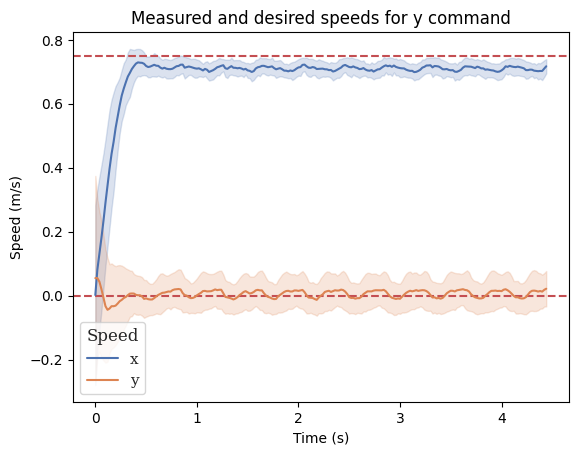

In [7]:
#Measured speed
fname = "plane-None-0.75-0.075-True"
metric = "slope" if "slope" in fname else "height"
with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname+'.json'), 'r') as file:
    data = json.load(file)[0]  # Load and parse the JSON file

speed_x = data["vel_x"]
speed_y = data["vel_y"]

plt.figure()
plt.axhline(y=float(fname.split("-")[-3]), color='r', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Measured and desired speeds for y command")
plot_error_lineplots([speed_x, speed_y], xlabel="Time (s)", ylabel="Speed (m/s)", names=["x", "y"])
plt.show()

/home/zetans/anaconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/zetans/anaconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/zetans/anaconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


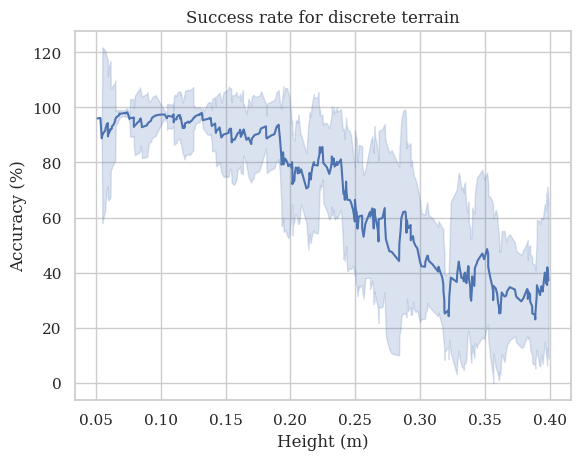

In [6]:
#Discrete
def myFunc(e):
  return e[metric]

#PATH = os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts')
PATH = "/home/zetans/Desktop/results_plots/terrain_accuracy/28_limit"
fname = "discrete-None-0.75-0.075-False"
metric = "slope" if "slope" in fname else "height"
with open(os.path.join(PATH,fname+'.json'), 'r') as file:
  data = json.load(file)  # Load and parse the JSON file

data.sort(key=myFunc)
accuracy = [item["successful"]*100/item["total"] for item in data]
slope = [item[metric] for item in data]

smoothing_plot(slope, accuracy, smooth_factor=0.1)
plt.xlabel('Slope' if metric=="slope" else "Height (m)")
plt.ylabel('Accuracy (%)')
plt.title('Success rate for '+fname.split("-")[0]+' terrain')
plt.show()

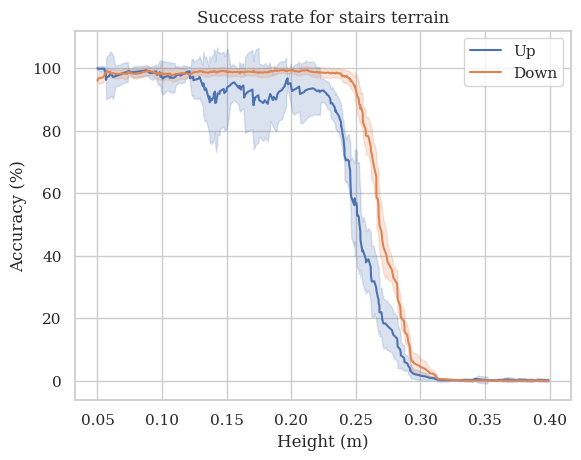

In [ ]:
#Slope or stairs
def myFunc(e):
  return e[metric]

def get_x_y(data):
    data.sort(key=myFunc)
    y = [item["successful"]*100/item["total"] for item in data]
    if metric=="slope":
        x = [np.rad2deg(np.arctan(item[metric])) for item in data]
    else:    
        x = [item[metric] for item in data]
    return x,y

PATH = "/home/zetans/Desktop/results_plots/terrain_accuracy/80_limit"
fname = "stairs-None-0.75-0.075-y"
metric = "slope" if "slope" in fname else "height"
with open(os.path.join(PATH, fname.replace("None", "False")+'.json'), 'r') as file:
    data_up = json.load(file)  # Load and parse the JSON file
with open(os.path.join(PATH, fname.replace("None", "True")+'.json'), 'r') as file:
    data_down = json.load(file)  # Load and parse the JSON file

x_down, y_down = get_x_y(data_down)
x_up, y_up = get_x_y(data_up)

smoothing_plot(x_down, y_down, smooth_factor=0.1, label="Up")
smoothing_plot(x_up, y_up, smooth_factor=0.1, label="Down")
plt.xlabel('Slope (°)' if metric=="slope" else "Height (m)")
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Success rate for '+fname.split("-")[0]+' terrain')
plt.show()

In [12]:
import json, os
import numpy as np
from scipy.spatial.transform import Rotation as R
fname = "init_poses_collected copy"
with open(fname+'.json', 'r') as file:
    data = json.load(file)  # Load and parse the JSON file
quaternions = data["base_orientation"]
euler_angles_list = [R.from_quat(quat).as_euler('xyz', degrees=True) for quat in quaternions]
euler_angles_list

[array([1.79999464e+02, 2.55509677e-03, 1.26528930e+02]),
 array([ 1.79999931e+02,  1.18739704e-03, -1.04016074e+02]),
 array([-1.79999953e+02,  1.51904990e-03, -1.26158198e+02]),
 array([-1.70027704e-04,  1.42521904e-03,  8.41896460e+01]),
 array([1.12842237e-04, 8.14269311e-04, 6.03943041e+01]),
 array([ -0.67734789,  25.04456733, -75.47665986]),
 array([ 2.78574216e-04,  7.83897695e-04, -5.94931913e+00]),
 array([-1.79999931e+02,  1.39361318e-03,  1.58111511e+02]),
 array([ -1.51884898, -24.14198159,  47.05317369]),
 array([  -5.11970116,  -81.60320848, -134.36765136]),
 array([ -0.18925045, -67.63502268,  36.06121897]),
 array([-1.79999981e+02,  1.64966374e-03, -3.21690430e+01]),
 array([-4.47836965e-04,  1.22163584e+01, -1.01866734e+02]),
 array([ -2.60670359, -20.02672034,  73.7623175 ]),
 array([1.79999236e+02, 2.89920297e-03, 9.48786071e+01]),
 array([-1.79999970e+02,  1.38054928e-03,  1.33744944e+01]),
 array([ 1.79999889e+02,  1.23352632e-03, -1.49360926e+02]),
 array([2.7406

Speed analsys

In [23]:
#Slope or stairs
def myFunc(e):
  return e[metric]
def get_speed(data):
    dir = fname[-1]
    y = [item[f"vel_{dir}"] for item in data]
    x = [item["commands"] for item in data]
    #Free memory usage
    y = np.array([[np.array(y[i][j], dtype=np.float32).mean(axis=0) for j in range(np.array(y).shape[1])] for i in range(np.array(y).shape[0])], dtype=object)
    return np.array(x), y
fname = "plane-None-0.75-0.075-w"
metric = "slope" if "slope" in fname else "height"
down = None
with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname.replace("None", str(down))+'.json'), 'r') as file:
    data = json.load(file)  # Load and parse the JSON file
commands, speeds = get_speed(data)
del data

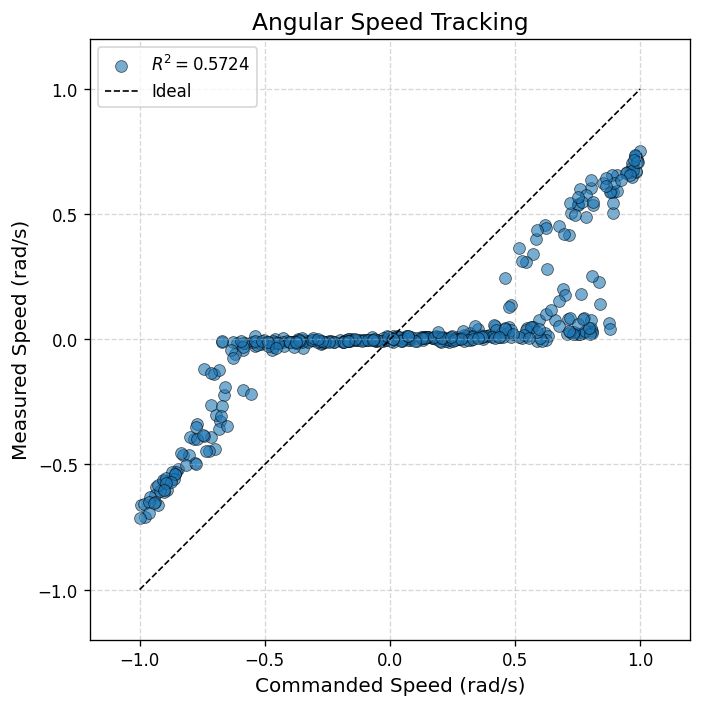

R² score: 0.5724243959946373


In [24]:
from sklearn.metrics import r2_score
idxs_dir = ["x", "y", "w"]
commanded_speed = commands[:, :, idxs_dir.index(fname[-1])][:, 0]
measured_speed = speeds[:, 0]
r2 = r2_score(commanded_speed, measured_speed)

# Scatter plot
unit = "rad/s" if idxs_dir.index(fname[-1])==2 else "m/s" 
titles =["Linear (x)", "Linear (y)", "Angular"]


# Scatter plot with styling
plt.figure(figsize=(6, 6), dpi=120)
plt.scatter(commanded_speed, measured_speed, 
            alpha=0.6, 
            edgecolor='k', 
            linewidth=0.5, 
            s=50, 
            label=f'$R^2 = {r2:.4f}$')
plt.plot([-1, 1], [-1, 1], 'k--', linewidth=1, label="Ideal")
plt.xlabel(f"Commanded Speed ({unit})", fontsize=12)
plt.ylabel(f"Measured Speed ({unit})", fontsize=12)
plt.title(f"{titles[idxs_dir.index(fname[-1])]} Speed Tracking", fontsize=14)
plt.xlim((-1.2, 1.2))
plt.ylim((-1.2, 1.2))
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

# Print R² score
print("R² score:", r2)

Torque analysis

In [ ]:
#Slope or stairs
def myFunc(e):
  return e[metric]
def get_torques(data):
    data.sort(key=myFunc)
    y = [item["torques"] for item in data]
    if metric=="slope":
        x = [np.rad2deg(np.arctan(item[metric])) for item in data]
    else:    
        x = [item[metric] for item in data]
    #Free memory usage
    y = np.array([[np.array(y[i][j], dtype=np.float32) for j in range(50)] for i in range(400)], dtype=object)
    return np.array(x), y
fname = "discrete-None-0.75-0.075-False"
metric = "slope" if "slope" in fname else "height"
down = None
with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname.replace("None", str(down))+'.json'), 'r') as file:
    data = json.load(file)  # Load and parse the JSON file
x, torques = get_torques(data)
del data

In [4]:
avg_torque = np.zeros((400, 12))

for i in range(400):  # Iterate over robots
    all_steps = np.concatenate(torques[i], axis=0)  # Flatten all 50 runs (n, 12) -> (sum(n), 12)
    avg_torque[i] = np.mean(np.abs(all_steps), axis=0)  # Compute mean per articulation

mean_per_joint = avg_torque.reshape(-1,4,3).mean(axis=1)
mean_per_leg = avg_torque.reshape(-1,4,3).mean(axis=2)

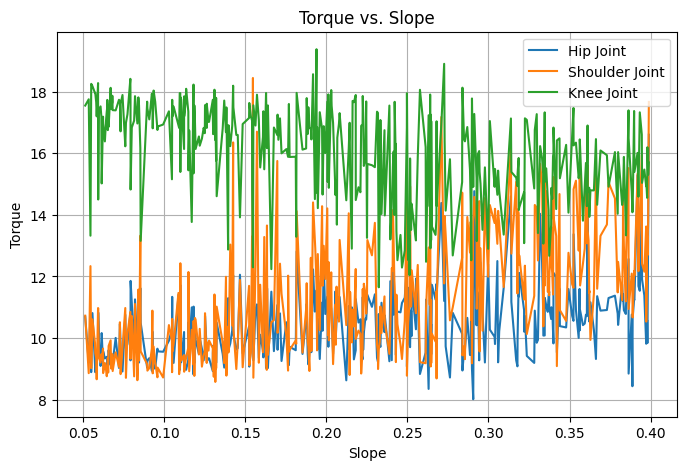

In [ ]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, mean_per_joint[:, 0], label='Hip Joint')
plt.plot(x, mean_per_joint[:, 1], label='Shoulder Joint')
plt.plot(x, mean_per_joint[:, 2], label='Knee Joint')

# Labels and legend
plt.xlabel("Slope")
plt.ylabel("Torque")
plt.title("Torque vs. Slope")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

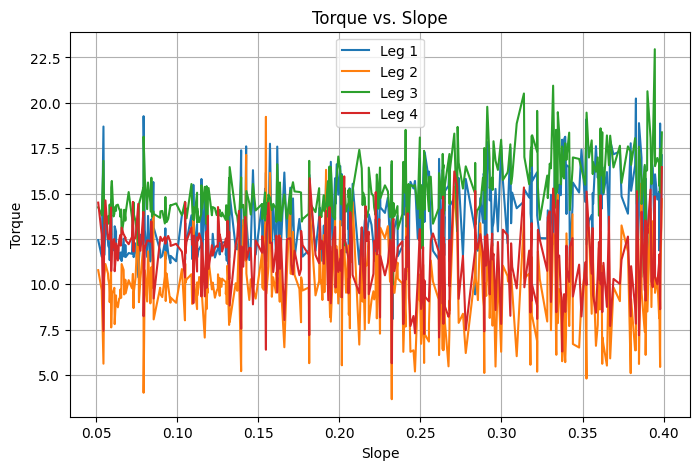

In [6]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, mean_per_leg[:, 0], label='Leg 1')
plt.plot(x, mean_per_leg[:, 1], label='Leg 2')
plt.plot(x, mean_per_leg[:, 2], label='Leg 3')
plt.plot(x, mean_per_leg[:, 3], label='Leg 4')

# Labels and legend
plt.xlabel("Slope")
plt.ylabel("Torque")
plt.title("Torque vs. Slope")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**All torque analysis - Irregular**

In [24]:
PATH = "/home/zetans/Desktop/results_plots/terrain_accuracy/28_limit"
#PATH = os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts')

In [25]:
#Slope or stairs
def myFunc(e):
  return e[metric]
def get_torques(path):
    with open(path, 'r') as file:
        data = json.load(file)  # Load and parse the JSON file
    data.sort(key=myFunc)
    y = [item["torques"] for item in data]
    #Free memory usage
    std_y = np.array([[np.abs(np.array(y[i][j], dtype=np.float32)).std(axis=0) for j in range(50)] for i in range(400)], dtype=object)
    #std_y = np.array([[np.max(np.abs(np.array(y[i][j], dtype=np.float32)), axis=0) - np.min(np.abs(np.array(y[i][j], dtype=np.float32)), axis=0) for j in range(50)] for i in range(400)], dtype=object)
    y = np.array([[np.abs(np.array(y[i][j], dtype=np.float32)).mean(axis=0) for j in range(50)] for i in range(400)], dtype=object)
    return std_y, y

In [72]:
from tqdm import tqdm
#iterations_values = [("slope", True), ("slope", False), ("stairs", True), ("stairs", False), ("discrete", None)]
iterations_values = [("slope", False), ("stairs", False)]
n = 20
group_difficulties = np.zeros((len(iterations_values), n, 50, 12))
group_difficulties_std = np.zeros((len(iterations_values), n, 50, 12))
for i, (terrain, down) in tqdm(enumerate(iterations_values)):
    fname = f"{terrain}-None-0.75-0.075-y"
    metric = "slope" if "slope" in fname else "height"
    path = os.path.join(PATH,fname.replace("None", str(down))+'.json')
    torques_std, torques = get_torques(path)
    group_difficulties[i] = (torques.reshape(n, -1, torques.shape[1], torques.shape[2])).mean(axis=1)
    group_difficulties_std[i] = (torques_std.reshape(n, -1, torques.shape[1], torques.shape[2])).mean(axis=1)

2it [03:20, 100.02s/it]


In [73]:
group_difficulties_joint = (group_difficulties.reshape(group_difficulties.shape[0], group_difficulties.shape[1], group_difficulties.shape[2], 2, 2, 3)).mean(axis=(0, 4))
group_difficulties_joint_std = (group_difficulties_std.reshape(group_difficulties.shape[0], group_difficulties.shape[1], group_difficulties.shape[2], 2, 2, 3)).mean(axis=(0, 4))

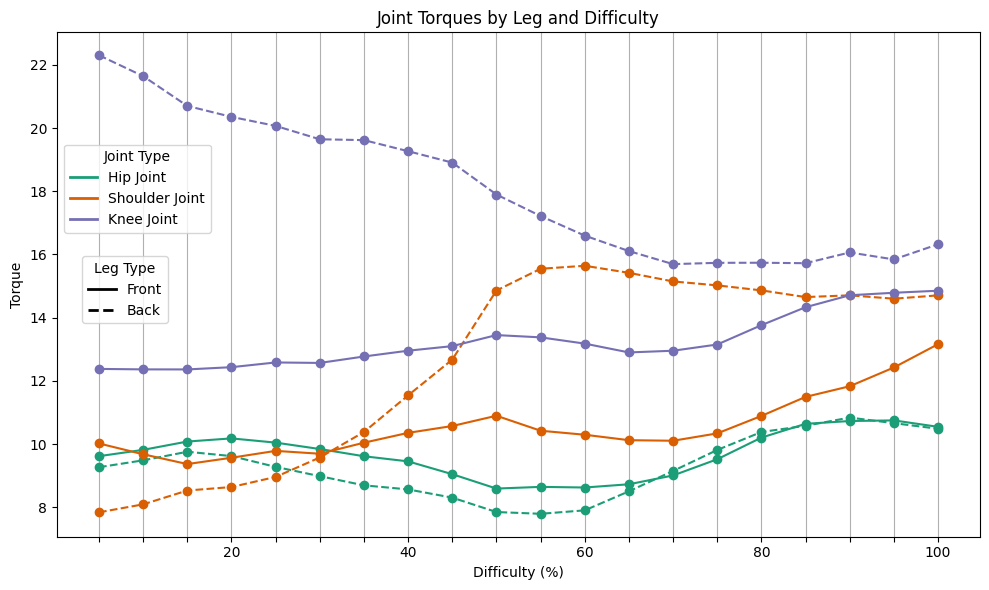

In [77]:
from matplotlib.lines import Line2D
# Compute mean and standard deviation over trials (axis=1)
mean_torque = np.mean(group_difficulties_joint, axis=1)  # Shape: (n, 2, 3)
std_torque = np.mean(group_difficulties_joint_std, axis=1)    # Shape: (n, 2, 3)

difficulties = np.arange(1, n+1)*5

motor_labels = ["Hip Joint", "Shoulder Joint", "Knee Joint"]
colors = ["#1b9e77", "#d95f02", "#7570b3"]
leg_labels = ["Front", "Back"]
line_styles = ["-", "--"]

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot data
for joint_idx in range(3):  # joints
    for leg_idx in range(2):  # legs
        ax.errorbar(
            difficulties,
            mean_torque[:, leg_idx, joint_idx],
            # yerr=std_torque[:, leg_idx, joint_idx],
            color=colors[joint_idx],
            linestyle=line_styles[leg_idx],
            capsize=4,
            marker='o'
        )

# First legend: Joint types (color)
joint_legend = [Line2D([0], [0], color=colors[i], lw=2) for i in range(3)]
legend1 = ax.legend(joint_legend, motor_labels, title="Joint Type", loc="center left", bbox_to_anchor=(0, 0.69))
ax.add_artist(legend1)

# Second legend: Leg types (line style)
leg_legend = [Line2D([0], [0], color='k', linestyle=line_styles[i], lw=2) for i in range(2)]
ax.legend(leg_legend, leg_labels, title="Leg Type", loc="center left", bbox_to_anchor=(0.02, 0.49))

ax.set_xlabel("Difficulty (%)")
ax.set_ylabel("Torque")
ax.set_title("Joint Torques by Leg and Difficulty")

# Grid on all x ticks
ax.set_xticks(difficulties)  # all ticks for grid lines
ax.grid(axis="x")

# Only 5 labels
selected_ticks = [20, 40, 60, 80, 100]
ax.set_xticks(difficulties)  # keep grid lines
ax.set_xticklabels([str(tick) if tick in selected_ticks else '' for tick in difficulties])

plt.tight_layout()
plt.show()

In [ ]:
data = {
    "difficulties": difficulties.tolist(),
    "torque_data": []
}
for i in range(3):
    motor_data = {
        "motor": motor_labels[i],
        "mean_torque": mean_torque[:, :, i].tolist(),
        "std_torque": std_torque[:, :, i].tolist()
    }
    data["torque_data"].append(motor_data)

# Write to JSON file
with open("torqueVSdifficulty_data_up.json", "w") as f:
    json.dump(data, f, indent=4)

**All torque analysis - Flat terrain**

In [81]:
PATH = "/home/zetans/Desktop/results_plots/speed_tracking"

In [82]:
def myFunc(e):
  return np.array(np.abs(e[metric])).mean()
  #return e["commands"][0][0]
def get_torques(path):
    with open(path, 'r') as file:
        data = json.load(file)  # Load and parse the JSON file
    data.sort(key=myFunc)
    y = [item["torques"] for item in data]
    #Free memory usage
    std_y = np.array([np.squeeze(np.abs(np.array(y[i], dtype=np.float32))).std(axis=0) for i in range(400)], dtype=object)
    #std_y = np.array([[np.max(np.abs(np.array(y[i][j], dtype=np.float32)), axis=0) - np.min(np.abs(np.array(y[i][j], dtype=np.float32)), axis=0) for j in range(50)] for i in range(400)], dtype=object)
    y = np.array([np.squeeze(np.abs(np.array(y[i], dtype=np.float32))).mean(axis=0) for i in range(400)], dtype=object)
    return std_y, y

In [84]:
from tqdm import tqdm
iterations_values = ["x", "y", "w"]
n = 20
group_speeds = np.zeros((len(iterations_values), n, 12))
group_speeds_std = np.zeros((len(iterations_values), n, 12))
for i, (direction) in tqdm(enumerate(iterations_values)):
    fname = f"plane-None-0.75-0.075-{direction}"
    metric = f"vel_{direction}"
    path = os.path.join(PATH,fname+'.json')
    torques_std, torques = get_torques(path)
    group_speeds[i] = (torques.reshape(n, -1, torques.shape[1])).mean(axis=1)
    group_speeds_std[i] = (torques_std.reshape(n, -1, torques.shape[1])).mean(axis=1)

3it [00:08,  2.68s/it]


In [85]:
group_speeds_joint = (group_speeds.reshape(group_speeds.shape[0], group_speeds.shape[1], 4, 3)).mean(axis=(0, 2))
group_speeds_joint_std = (group_speeds_std.reshape(group_speeds.shape[0], group_speeds.shape[1], 4, 3)).mean(axis=(0, 2))

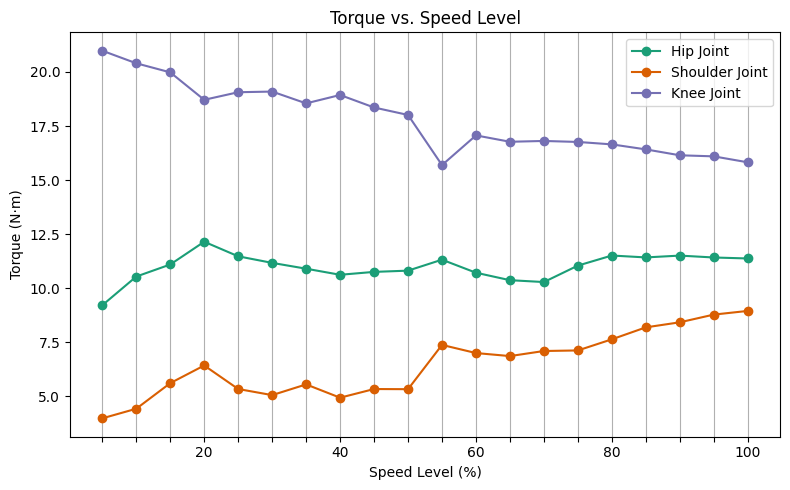

In [98]:
# Terrain difficulties (X-axis values)
difficulties = np.arange(1, n+1) * 5

# Elegant grayscale-friendly colors for paper
colors = ["#1b9e77", "#d95f02", "#7570b3"]
motor_labels = ["Hip Joint", "Shoulder Joint", "Knee Joint"]

# Plot setup
plt.figure(figsize=(8, 5))
ax = plt.gca()

# Plot lines
for i in range(3):
    ax.errorbar(
        difficulties,
        group_speeds_joint[:, i],
        # yerr=group_speeds_joint_std[:, i],
        label=motor_labels[i],
        color=colors[i],
        capsize=4,
        marker='o'
    )

# Axis labels and title
ax.set_xlabel("Speed Level (%)")
ax.set_ylabel("Torque (N·m)")
ax.set_title("Torque vs. Speed Level")

# Legend
ax.legend()

# Grid on all x ticks
ax.set_xticks(difficulties)  # keeps grid lines

# Only 5 x-axis tick labels shown
selected_ticks = [20, 40, 60, 80, 100]
ax.set_xticklabels([str(tick) if tick in selected_ticks else '' for tick in difficulties])

# Draw vertical grid lines
ax.grid(axis="x")

plt.tight_layout()
plt.show()

In [96]:
data = {
    "speeds": difficulties.tolist(),
    "torque_data": []
}
for i in range(3):
    motor_data = {
        "motor": motor_labels[i],
        "mean_torque": mean_torque[:, :, i].tolist(),
        "std_torque": std_torque[:, :, i].tolist()
    }
    data["torque_data"].append(motor_data)

# Write to JSON file
with open("torqueVSspeed_data.json", "w") as f:
    json.dump(data, f, indent=4)